# Example: Mixed-Element Mesh for Delineated Subwatersheds

This notebook demonstrates how to create stream-aligned meshes for subcatchments and subwatersheds. The triangulation respects subwatershed boundaries, enabling the creation of distinct regions for surface and subsurface domains along with their respective boundaries. This approach facilitates monitoring of subdomain-specific fluxes and states, as well as performing detailed water balance analyses for individual subdomains. 

In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)


In [3]:
import os,sys
import logging

import numpy as np
import pandas
pandas.set_option('display.max_columns', None) 
import geopandas
from matplotlib import pyplot as plt
import shapely
import pickle

import watershed_workflow 
import watershed_workflow.sources
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.sources.standard_names as names



In [4]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating


# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000


log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [5]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [6]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [7]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2026-02-06 16:06:58,794 - root - INFO: 
2026-02-06 16:06:58,794 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2026-02-06 16:06:58,795 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [9]:
# set up a dictionary of source objects
sources = watershed_workflow.sources.getDefaultSources()
sources['hydrography'] = watershed_workflow.sources.hydrography_sources['NHDPlus MR v2.1']
sources['HUC'] = watershed_workflow.sources.huc_sources['WaterData WBD']
watershed_workflow.sources.logSources(sources)

2026-02-06 16:06:58,845 - root - INFO: Using sources:
2026-02-06 16:06:58,845 - root - INFO: --------------
2026-02-06 16:06:58,845 - root - INFO: HUC: WBD
2026-02-06 16:06:58,846 - root - INFO: hydrography: NHDPlus MR v2.1
2026-02-06 16:06:58,846 - root - INFO: DEM: 3DEP 60m
2026-02-06 16:06:58,846 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2026-02-06 16:06:58,847 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2026-02-06 16:06:58,847 - root - INFO: land cover: NLCD 2021 L48
2026-02-06 16:06:58,847 - root - INFO: LAI: MODIS
2026-02-06 16:06:58,847 - root - INFO: depth to bedrock: raster: "average_soil_and_sedimentary-deposit_thickness.tif"
2026-02-06 16:06:58,848 - root - INFO: meteorology: AORC v1.1


# Basin Geometry

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

## the Watershed

Note the internal boundaries in the domain for subwatersheds.

2026-02-06 16:07:01,722 - root - INFO: fixing column: geometry
2026-02-06 16:07:01,736 - root - INFO: Removing holes on 3 polygons
2026-02-06 16:07:01,737 - root - INFO:   -- removed interior
2026-02-06 16:07:01,740 - root - INFO:   -- union
2026-02-06 16:07:01,740 - root - INFO: Parsing 1 components for holes
2026-02-06 16:07:01,741 - root - INFO:   -- complete


<Axes: >

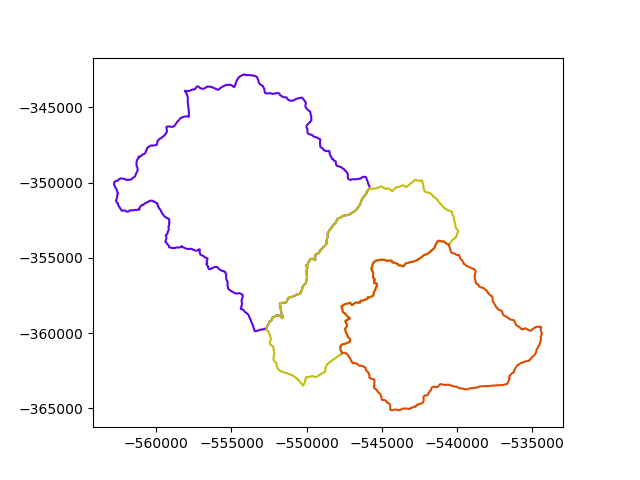

In [10]:
# load the huc
sources['HUC'].setLevel(huc_level)
my_hucs = sources['HUC'].getShapesByID(hucs, out_crs=crs)
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)
watershed.plot()

## the Rivers 

In [11]:
# download/collect the river network within that shape's bounds
reaches = sources['hydrography'].getShapesByGeometry(watershed.exterior, crs, out_crs=crs)
list(reaches.keys())

2026-02-06 16:07:03,795 - root - INFO: fixing column: geometry
2026-02-06 16:07:03,801 - root - INFO: fixing column: catchment


['geometry',
 'comid',
 'fdate',
 'resolution',
 'gnis_id',
 'reachcode',
 'flowdir',
 'wbareacomi',
 'ftype',
 'fcode',
 'shape_length',
 'streamleve',
 'streamcalc',
 'fromnode',
 'tonode',
 'levelpathi',
 'pathlength',
 'terminalpa',
 'arbolatesu',
 'startflag',
 'terminalfl',
 'dnlevel',
 'uplevelpat',
 'dnlevelpat',
 'dnminorhyd',
 'dndraincou',
 'frommeas',
 'tomeas',
 'rtndiv',
 'vpuin',
 'vpuout',
 'divdasqkm',
 'tidal',
 'totma',
 'wbareatype',
 'pathtimema',
 'hwnodesqkm',
 'maxelevraw',
 'minelevraw',
 'maxelevsmo',
 'minelevsmo',
 'slope',
 'elevfixed',
 'hwtype',
 'slopelenkm',
 'qa_ma',
 'va_ma',
 'qc_ma',
 'vc_ma',
 'qe_ma',
 've_ma',
 'qa_01',
 'va_01',
 'qc_01',
 'vc_01',
 'qe_01',
 've_01',
 'qa_02',
 'va_02',
 'qc_02',
 'vc_02',
 'qe_02',
 've_02',
 'qa_03',
 'va_03',
 'qc_03',
 'vc_03',
 'qe_03',
 've_03',
 'qa_04',
 'va_04',
 'qc_04',
 'vc_04',
 'qe_04',
 've_04',
 'qa_05',
 'va_05',
 'qc_05',
 'vc_05',
 'qe_05',
 've_05',
 'qa_06',
 'va_06',
 'qc_06',
 'vc_06',
 '

In [12]:
# from the generic linestrings, connect them to form trees
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers

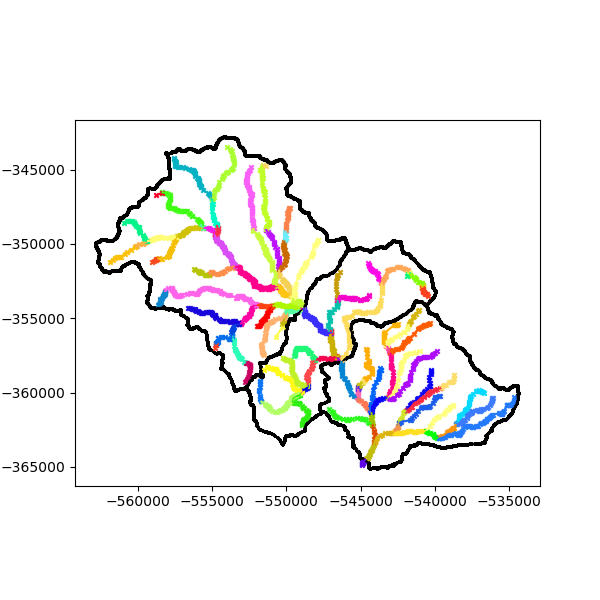

In [13]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)


plot(watershed, rivers)


In [14]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]


In [15]:
   
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# prune
rivers = watershed_workflow.reduceRivers(rivers, 
                                         prune_by_area=prune_by_area_fraction * watershed.exterior.area/1e6,
                                         remove_diversions=True,
                                         remove_braided_divergences=True)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

# greatly shrunk the rivers... shrink the dataframe too
for river in rivers:
    river.resetDataFrame()

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

2026-02-06 16:07:04,211 - root - INFO: Removing rivers with area < 6.073632854502017
2026-02-06 16:07:04,212 - root - INFO:  ... removed 0 rivers
2026-02-06 16:07:04,212 - root - INFO: Removing divergent sections...
2026-02-06 16:07:04,213 - root - INFO:   ... removed 0 divergence tributaries with 0 total reaches.
2026-02-06 16:07:04,243 - root - INFO: ... pruned 53 of 113
2026-02-06 16:07:04,244 - root - INFO: 
2026-02-06 16:07:04,244 - root - INFO: Simplifying
2026-02-06 16:07:04,244 - root - INFO: ------------------------------
2026-02-06 16:07:04,244 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2026-02-06 16:07:04,244 - root - INFO: Presimplify to remove colinear, coincident points.
2026-02-06 16:07:04,248 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2026-02-06 16:07:04,248 - root - INFO: Pruning leaf reaches < 75
2026-02-06 1

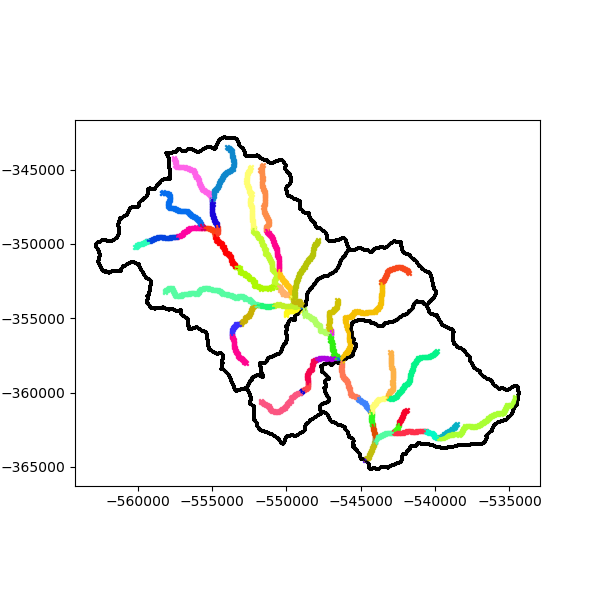

In [16]:
plot(watershed, rivers)

In [17]:
watershed.exterior_outlet = shapely.geometry.Point(rivers[0].linestring.coords[-1])

In [18]:
rivers[0].df.keys()

Index(['geometry', 'comid', 'fdate', 'resolution', 'gnis_id', 'reachcode',
       'flowdir', 'wbareacomi', 'ftype', 'fcode',
       ...
       'name', 'length', 'stream_order', 'drainage_area_sqkm', 'catchment',
       'hydroseq', 'uphydroseq', 'dnhydroseq', 'divergence', 'do-not-merge'],
      dtype='object', length=146)

In [19]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = None
m = watershed.explore(m=m, marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    #m = river.df.explore(m=m)
    m = river.explore(m=m)
    
m = watershed_workflow.makeMap(m)
m

In [20]:
# checkpoint here, saving both rivers and hucs to disk
# note, this is the preferred way to save a list of rivers!
river_df = pandas.concat([river.to_dataframe() for river in rivers])
river_df.to_parquet(name + '_rivers.parquet')
with open(name+'_watersheds.pickle', 'wb') as fid:
    pickle.dump(watershed, fid)
    

## Mesh Geometry

Discretely create the stream-aligned mesh.  Download elevation data, and condition the mesh discretely to make for better topography.

In [21]:
# if loading from checkpoint, skip the previous subsubsection
reaches_df = geopandas.read_parquet(name+'_rivers.parquet')
rivers = watershed_workflow.river_tree.createRivers(reaches_df, method='native')

with open(name+'_watersheds.pickle', 'rb') as fid:
    watershed = pickle.load(fid)

In [22]:
# how many types of Stream Orders are there
set([r[names.ORDER] for r in rivers[0].preOrder()])

{np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

2026-02-06 16:09:23,266 - root - INFO: 
2026-02-06 16:09:23,267 - root - INFO: Stream-aligned Meshing
2026-02-06 16:09:23,267 - root - INFO: ------------------------------
2026-02-06 16:09:23,268 - root - INFO: Creating stream-aligned mesh...
2026-02-06 16:09:23,429 - root - INFO: Adjusting HUC to match reaches at outlet
2026-02-06 16:09:23,433 - root - INFO: Adjusting HUC to match reaches at reach 6 and coordinate (-546348.9429845376, -357841.9509549553)
2026-02-06 16:09:23,438 - root - INFO: Adjusting HUC to match reaches at reach 14 and coordinate (-548915.8617565744, -354311.3539136959)
2026-02-06 16:09:23,455 - root - INFO: Plotting the river mesh
2026-02-06 16:09:26,063 - root - INFO:   is nonoverlapping?  total_area = 1679489.488460845, summed_area = 1679489.4884609545


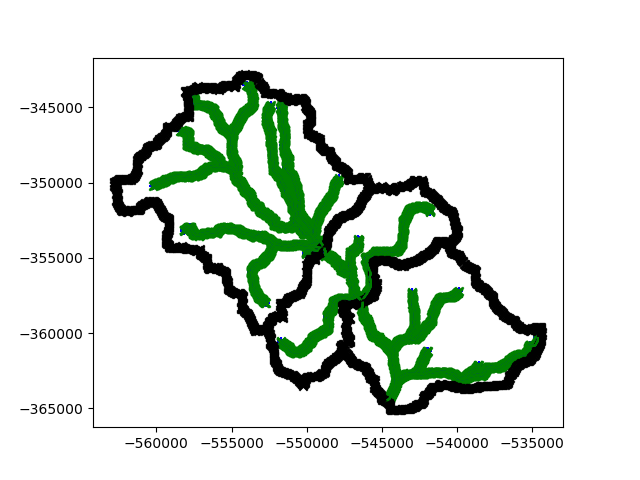

2026-02-06 16:09:26,307 - root - INFO: 
2026-02-06 16:09:26,307 - root - INFO: Triangulation
2026-02-06 16:09:26,308 - root - INFO: ------------------------------
2026-02-06 16:09:26,323 - root - INFO: Triangulating...
2026-02-06 16:09:26,332 - root - INFO:    5220 points and 5225 facets
2026-02-06 16:09:26,333 - root - INFO:  checking graph consistency
2026-02-06 16:09:26,333 - root - INFO:  tolerance is set to 1.0
2026-02-06 16:09:26,377 - root - INFO:  building graph data structures
2026-02-06 16:09:26,419 - root - INFO:  triangle.build...
2026-02-06 16:11:16,980 - root - INFO:   ...built: 13014 mesh points and 21189 triangles
2026-02-06 16:11:16,981 - root - INFO: Splitting stream triangles
2026-02-06 16:11:19,609 - root - INFO: Split 158 stream triangles
2026-02-06 16:11:19,609 - root - INFO: Plotting triangulation diagnostics
2026-02-06 16:11:20,251 - root - INFO:   min area = 55.38462829589844
2026-02-06 16:11:20,251 - root - INFO:   max area = 49989.87419128418


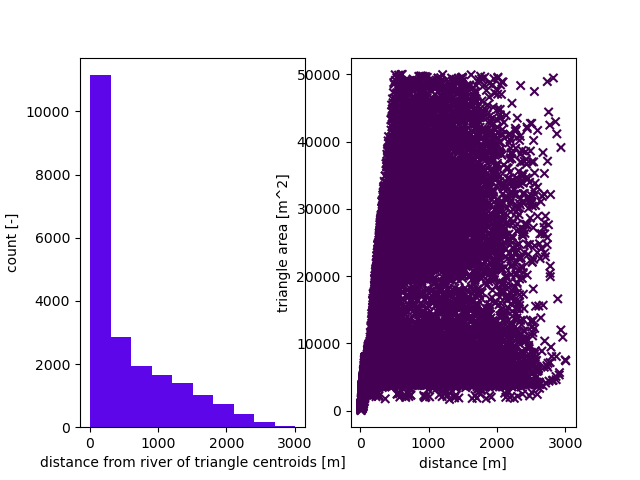

In [26]:
## Triangulation

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
def widths(reach):
    mapping = {1: 10, 2: 10, 3: 20, 4: 30}
    order = reach.properties['stream_order']  # default to 1 if not found
    return mapping.get(order, 10)  # default width if order not found

m2, area, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True, debug=True)

In [27]:
# get a dem dataset and elevate the mesh according to interpolation of those elevations
dem = sources['DEM'].getDataset(watershed.exterior, watershed.crs)['dem']
watershed_workflow.elevate(m2, dem, method='linear')

# note, if this fails, may need to increase the resolution buffer on the manager, by setting
#sources['DEM'].native_resolution = sources['DEM'].native_resolution * 2
assert not any(np.isnan(m2.coords[:,-1]))



2026-02-06 16:12:03,754 - root - INFO: Incoming shape area = 0.034510681863139915
2026-02-06 16:12:03,756 - root - INFO: ... buffering incoming shape by three times the native resolution = 0.00324
2026-02-06 16:12:03,758 - root - INFO: ... buffered shape area = 0.037836921974237374
2026-02-06 16:12:03,759 - root - INFO: Getting DEM with map of area = 0.037836921974237374


In [28]:
watershed.crs

<Projected CRS: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=- ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

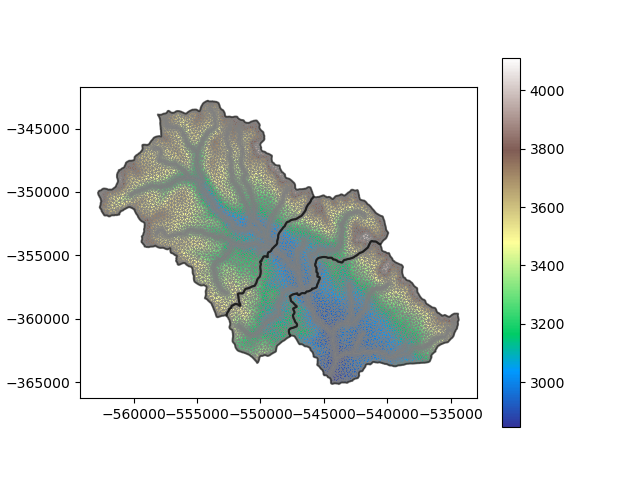

In [29]:
fig, ax = plt.subplots()
m2.plot(facecolors='elevation', ax=ax)
watershed.plot(ax=ax, color='k', alpha=0.5)
plt.show()

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [30]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [31]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

2026-02-06 16:12:07,738 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


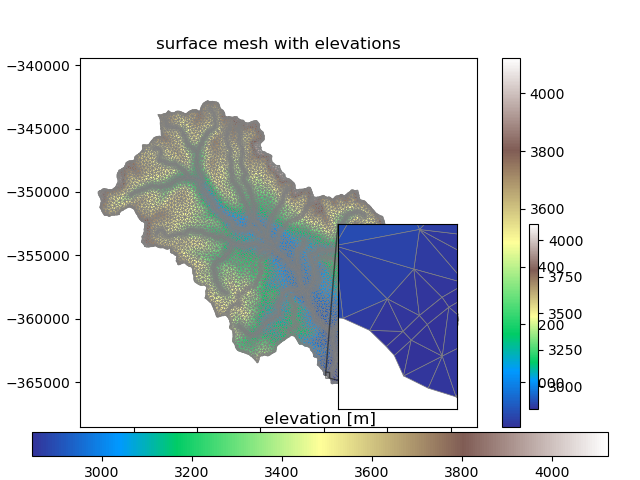

In [32]:
# plotting surface mesh with elevations
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, norm=norm)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2)
ax2.set_aspect('equal', 'datalim')

xlim =(-544850, -544550)
ylim = (-364650, -364250)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [33]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=stream_outlet_width, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.addStreamOrderRegions(m2, rivers)

2026-02-06 16:12:08,247 - root - INFO: Adding regions for 3 polygons
2026-02-06 16:12:08,655 - root - INFO: Exterior outlet point (from attribute): POINT (-544718.136159772 -364537.46515303734)


Note the regions specific to subcatchments

In [34]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 11691 : "Headwaters Taylor River"
10001 : CELL : 11691 : "Headwaters Taylor River surface"
10002 : CELL : 5170 : "Upper Taylor River"
10003 : CELL : 5170 : "Upper Taylor River surface"
10004 : CELL : 6266 : "Middle Taylor River"
10005 : CELL : 6266 : "Middle Taylor River surface"
10006 : FACE : 825 : "Headwaters Taylor River boundary"
10007 : FACE : 16 : "Headwaters Taylor River outlet"
10008 : FACE : 636 : "Upper Taylor River boundary"
10009 : FACE : 17 : "Upper Taylor River outlet"
10010 : FACE : 599 : "Middle Taylor River boundary"
10011 : FACE : 17 : "Middle Taylor River outlet"
10012 : FACE : 17 : "surface domain outlet"
10013 : CELL : 1780 : "river corridor 0 surface"
10014 : CELL : 187 : "stream order 4"
10015 : CELL : 599 : "stream order 2"
10016 : CELL : 800 : "stream order 1"
10017 : CELL : 194 : "stream order 3"
